This notebook uses the Scientific Python (scipy) stack tools to generate flow duration curves from current USGS NWIS data.

Using recipes from this notebook, you can make:
* USGS Station Summaries
* Flow duration curves
* Iterative import and compilation of USGS station information and data
* boxplots using pandas
* iterative charts (one monthly summary boxplot per station)
* Gantt charts of USGS stations

Check out this for some great `pandas` applications:
http://earthpy.org/time_series_analysis_with_pandas_part_2.html

In [1]:
%matplotlib inline
import pandas as pd
import platform
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

This following the suggested import call for the well application function.

In [3]:
import wellapplication as wa

In [5]:
print("Operating System " + platform.system() + " " + platform.release())
print("Python Version " + str(sys.version))
print("Pandas Version " + str(pd.__version__))
print("Numpy Version " + str(np.__version__))
print("Matplotlib Version " + str(matplotlib.__version__))
print("WellApplication Version " + str(wa.__version__))

Operating System Linux 4.4.0-59-generic
Python Version 2.7.11+ (default, Apr 17 2016, 14:00:29) 
[GCC 5.3.1 20160413]
Pandas Version 0.19.1
Numpy Version 1.11.2
Matplotlib Version 1.5.3
WellApplication Version 0.4.21


Call function class nwis and assign it as USGS.  This will allow for the implementation of all of the usgs functions.  This function class allows for the import of USGS data.

In [6]:
USGS = wa.nwis('gwlevels',[16020301],'huc')

connection successful


Once the class sucessfully connects, it downloads abbreviated site information and data for the location values entered.  The data can be accessed as objects of the variable assigned to the class.

In [7]:
siteinfo = USGS.sites
wldata = USGS.data
siteinfo.head()

,data_type_cd,dec_coord_datum_cd,dec_lat_va,dec_long_va,site_no,station_nm
0,GW,EPSG:4326,38.405806,-114.088444,382421114051801,196 N06 E70 02DDBB1 HAMLIN WELL
1,GW,EPSG:4326,38.504056,-114.204806,383023114115301,196 N08 E69 35CDDD1 USGS-MX
2,GW,EPSG:4326,38.503722,-114.206500,383023114115302,196 N07 E69 02BABA2 USGS-MX (Hamlin Valley...
3,GW,EPSG:4326,38.514167,-114.177028,383047114110001,196 N08 E69 36ADAA1 USBLM - ROSENCRANS WELL
4,GW,EPSG:4326,38.544611,-114.121500,383252114075101,196 N08 E70 21AADA1 TAIT WELL


For a more rigourous description of the sites, call `get_info()` on the class. We use the rest arguement `hasDataTypeCd` to select only sites with groundwater level (`gw`) data.

In [8]:
detail_siteinfo = USGS.get_info(hasDataTypeCd='gw')
detail_siteinfo.head()

connection successful
https://waterservices.usgs.gov/nwis/site/?hasDataTypeCd=gw&endDT=2017-02-07&format=rdb&startDT=1800-01-01&huc=16020301


,agency_cd,site_no,station_nm,site_tp_cd,dec_lat_va,dec_long_va,coord_acy_cd,dec_coord_datum_cd,alt_va,alt_acy_va,alt_datum_cd,huc_cd
0,USGS,382421114051801,196 N06 E70 02DDBB1 HAMLIN WELL,GW,38.405806,-114.088444,1,NAD83,5925.0,10.0,NGVD29,16020301
1,USGS,383023114115301,196 N08 E69 35CDDD1 USGS-MX,GW,38.504056,-114.204806,1,NAD83,5820.0,10.0,NGVD29,16020301
2,USGS,383023114115302,196 N07 E69 02BABA2 USGS-MX (Hamlin Valley...,GW,38.503722,-114.206500,1,NAD83,5839.0,10.0,NGVD29,16020301
3,USGS,383047114110001,196 N08 E69 36ADAA1 USBLM - ROSENCRANS WELL,GW,38.514167,-114.177028,1,NAD83,5761.0,10.0,NGVD29,16020301
4,USGS,383252114075101,196 N08 E70 21AADA1 TAIT WELL,GW,38.544611,-114.121500,1,NAD83,5707.0,10.0,NGVD29,16020301


We can clean up the value data to improve the quality and select a single station.

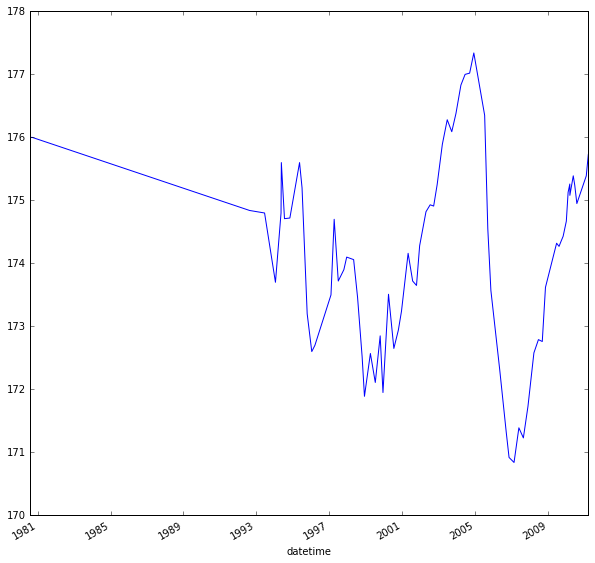

In [9]:
clean_wl = USGS.cleanGWL(wldata)
onesite = clean_wl[(clean_wl['value']>0)&(clean_wl.index.get_level_values('site_no') == '383023114115302')]
onesite.reset_index(inplace=True)
onesite.set_index('datetime',inplace=True)
onesite['value'].plot()

Use the `get_elev` function to call the point elevation service of the USGS. The Elevation Point Query Service <a href=http://ned.usgs.gov/epqs/> EPQS </a>

In [10]:
siteinfo['Elev'] = siteinfo[['dec_long_va','dec_lat_va']].apply(lambda x: wa.get_elev(x),1)

The default site data provide the HUC 8.  You can use ESRI services to get the 12-digit HUC and the HUC name.

In [11]:
siteinfo['HUC12'] = siteinfo[['dec_long_va','dec_lat_va']].apply(lambda x: wa.get_huc(x),1)

In [12]:
siteinfo.head()

,data_type_cd,dec_coord_datum_cd,dec_lat_va,dec_long_va,site_no,station_nm,Elev,HUC12
0,GW,EPSG:4326,38.405806,-114.088444,382421114051801,196 N06 E70 02DDBB1 HAMLIN WELL,1805.51,"(160203010305, Cobb Creek-Hamlin Valley Wash)"
1,GW,EPSG:4326,38.504056,-114.204806,383023114115301,196 N08 E69 35CDDD1 USGS-MX,1774.65,"(160203010201, West Ditch)"
2,GW,EPSG:4326,38.503722,-114.206500,383023114115302,196 N07 E69 02BABA2 USGS-MX (Hamlin Valley...,1780.07,"(160203010201, West Ditch)"
3,GW,EPSG:4326,38.514167,-114.177028,383047114110001,196 N08 E69 36ADAA1 USBLM - ROSENCRANS WELL,1756.52,"(160203010202, Rosencrans Creek)"
4,GW,EPSG:4326,38.544611,-114.121500,383252114075101,196 N08 E70 21AADA1 TAIT WELL,1740.02,"(160203010310, Miller Wash-Hamlin Valley Wash)"


The `avg_wl()` function can produce an average monthly changes over time

In [13]:
df = USGS.avg_wl()

/home/pi/Documents/Github/venv/local/lib/python2.7/site-packages/pandas/core/indexing.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/pi/Documents/Github/venv/local/lib/python2.7/site-packages/pandas/core/indexing.py:476: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


The function will produce mean HUC-wide groundwater level trends over time.

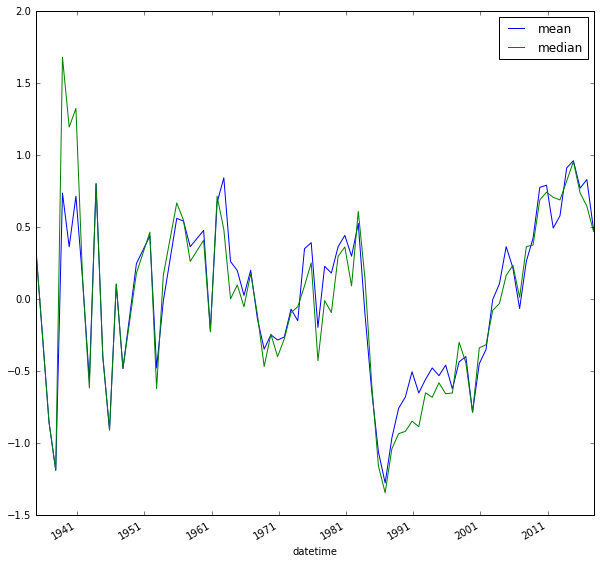

In [14]:
df[['mean','median']].plot()

Individual sites and time periods can also be specified.

In [15]:
USGS = wa.nwis('dv', 10109000,'site',startDT='1965-01-01',endDT='1975-01-01')

connection successful


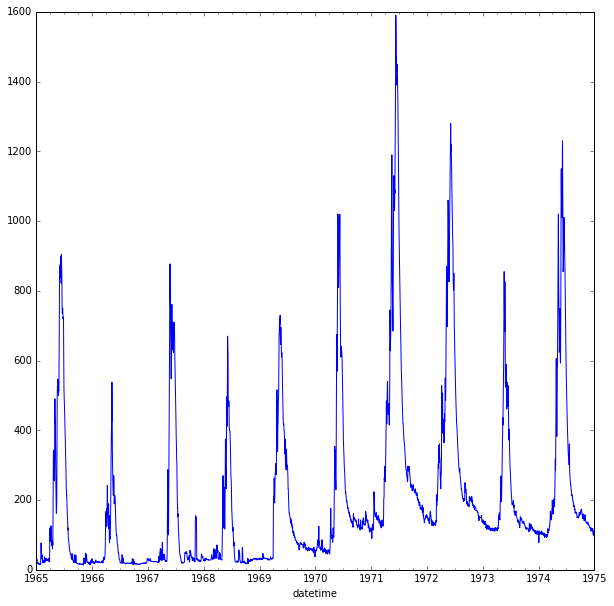

In [16]:
USGS.data.value.plot()

The heat map function can create a heat map hydrograph of an existing wellapplication object.

(1965, 1974)

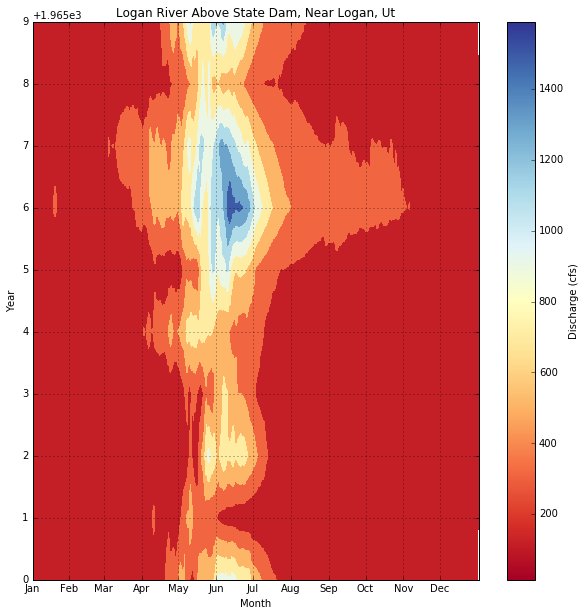

In [18]:
USGS.nwis_heat_map()
plt.ylim(1965,1974)

The package also comes with a built-in flow duration curve.

connection successful


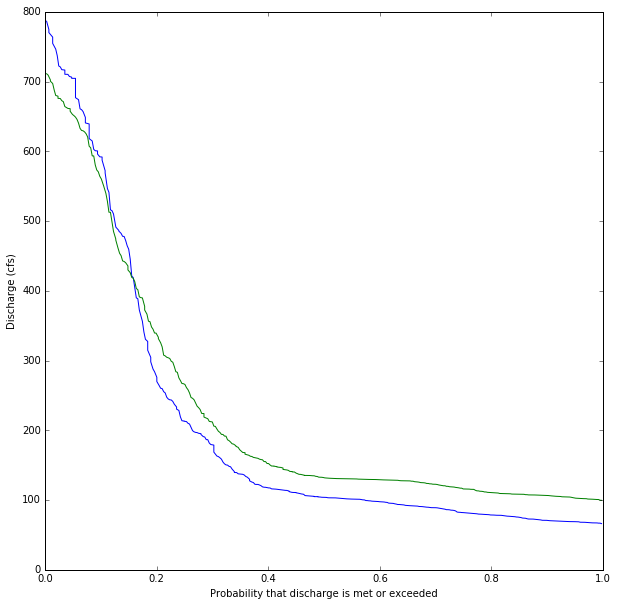

In [24]:
df = wa.fdc(USGS.data,'value')

USGS2 = wa.nwis('dv', 10109000,'site',startDT='1975-01-01')

df2 = wa.fdc(USGS2.data,'value')

plt.ylabel('Discharge (cfs)')
plt.xlabel('Probability that discharge is met or exceeded')

The fdc function also creates datasets for analysis.

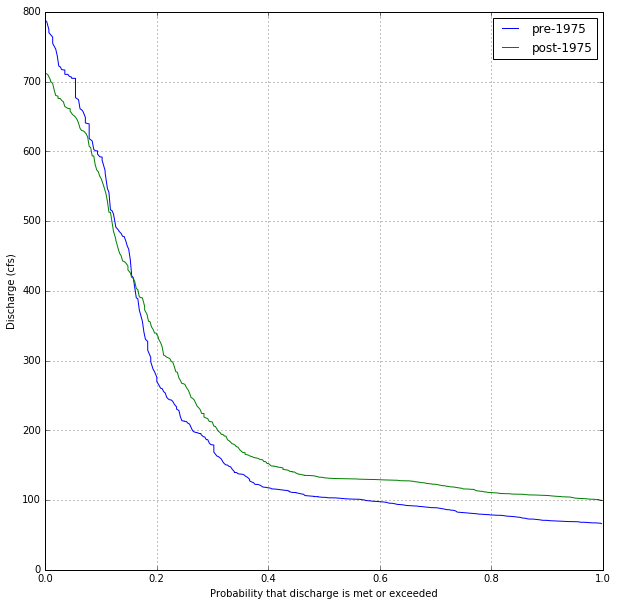

In [27]:
plt.figure()
plt.plot(df[0],df[1], label = 'pre-1975')
plt.plot(df2[0],df2[1], label = 'post-1975')
plt.legend()
plt.ylabel('Discharge (cfs)')
plt.xlabel('Probability that discharge is met or exceeded')
plt.grid()